In [1]:
from google.colab import drive
drive.mount('/content/drive')

device = 'cuda'
print('Running on GPU')

Mounted at /content/drive
Running on GPU


In [2]:
import os
import time
import datetime
import pickle
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

from numpy.linalg import inv
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils.validation import check_is_fitted
import joblib

In [3]:
!curl "https://drive.usercontent.google.com/download?id={1uqYWgQ8Lh0UGXTslAfy8lu1dGtBudBGL}&confirm=xxx" -o "acds3-wildfire-logan.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  161M  100  161M    0     0  26.2M      0  0:00:06  0:00:06 --:--:-- 32.8M


In [4]:
# Define the zip file name
zip_file_name = "acds3-wildfire-logan.zip"

# Get the absolute path of the zip file
zip_file_path = os.path.abspath(zip_file_name)

# Print the path of the zip file
print(f"Zip file path: {zip_file_path}")

Zip file path: /content/acds3-wildfire-logan.zip


In [5]:
# Extract the training data
with zipfile.ZipFile("./acds3-wildfire-logan.zip", 'r') as z:
    z.extractall('./Mydrive/acds3-wildfire-logan/')

In [6]:
# Paths to the .npy files
train_path = './Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/Ferguson_fire_train.npy'
background_path = './Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/Ferguson_fire_background.npy'
obs_path = './Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/Ferguson_fire_obs.npy'

# Load the .npy files
train_data = np.load(train_path)
background_data = np.load(background_path)
obs_data = np.load(obs_path)

In [7]:
train_data.shape, background_data.shape, obs_data.shape

((12500, 256, 256), (5, 256, 256), (5, 256, 256))

In [8]:
train_1D = np.reshape(
    train_data, (np.shape(train_data)[0], np.shape(train_data)[1] * np.shape(train_data)[2])
)

background_1D = np.reshape(
    background_data, (np.shape(background_data)[0], np.shape(background_data)[1] * np.shape(background_data)[2])
)

obs_1D = np.reshape(
    obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])
)

print('Train Data Before reshaping:', train_data.shape)
print('Train Data After reshaping:', train_1D.shape)
print('Background Data Before reshaping:', background_data.shape)
print('Background Data After reshaping:', background_1D.shape)
print('Observe Data Before reshaping:', obs_data.shape)
print('Observe Data After reshaping:', obs_1D.shape)

Train Data Before reshaping: (12500, 256, 256)
Train Data After reshaping: (12500, 65536)
Background Data Before reshaping: (5, 256, 256)
Background Data After reshaping: (5, 65536)
Observe Data Before reshaping: (5, 256, 256)
Observe Data After reshaping: (5, 65536)


In [9]:
train_1D.shape, background_1D.shape, obs_1D.shape

((12500, 65536), (5, 65536), (5, 65536))

### Perform PCA covariance matrix

In [10]:
# Set the number of components and batch size
n_components = 307
batch_size = 2000

# Initialize IncrementalPCA
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Fit the model in batches
for i in tqdm(range(0, train_1D.shape[0], batch_size), desc="Fitting batches"):
    batch = train_1D[i:i + batch_size]
    ipca.partial_fit(batch)

# Ensure the model is fitted
try:
    check_is_fitted(ipca, 'components_')
    print("IPCA model is fitted and ready for transformation.")
except NotFittedError as e:
    print(f"Model is not fitted yet: {e}")

# Transform the data in batches
train_reduced = []
for i in tqdm(range(0, train_1D.shape[0], batch_size), desc="Transforming batches"):
    batch = train_1D[i:i + batch_size]
    train_reduced.append(ipca.transform(batch))

train_reduced = np.vstack(train_reduced)

# Print the shapes of the original and reduced data
print("Original shape:", train_1D.shape)
print("Reduced shape:", train_reduced.shape)

Fitting batches: 100%|██████████| 7/7 [04:29<00:00, 38.56s/it]


IPCA model is fitted and ready for transformation.


Transforming batches: 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]

Original shape: (12500, 65536)
Reduced shape: (12500, 307)


In [11]:
# Save the IPCA model
joblib_file = "./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/incremental_pca_model.pkl"
joblib.dump(ipca, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to ./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/incremental_pca_model.pkl


In [12]:
# Load the IPCA model
ipca_loaded = joblib.load(joblib_file)
ipca = ipca_loaded
print("Model loaded successfully.")

Model loaded successfully.


### Import Rnn Predict image

In [13]:
from PIL import Image
# Define the image path
rnn_pred_path = './Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/rnn_output_image.npy'

rnn_pred_image = np.load(rnn_pred_path)
print("Shape of the predict image:", rnn_pred_image.shape)

Shape of the predict image: (1, 256, 256)


New data shape: (5, 256, 256)


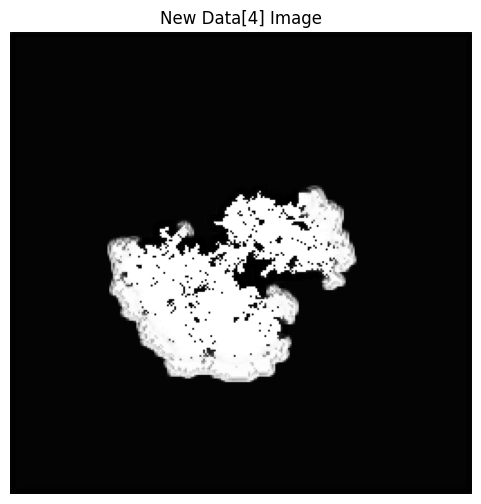

In [14]:
# 生成新的数据集，由 background_data 的前四个图像和 rnn_pred_image 组成
new_data = np.zeros((5, 256, 256))
new_data[:4] = background_data[:4]
new_data[4] = rnn_pred_image
print("New data shape:", new_data.shape)

# 绘制新的数据集中的第5个图像
plt.figure(figsize=(6, 6))
plt.imshow(new_data[4], cmap='gray')
plt.title('New Data[4] Image')
plt.axis('off')
plt.show()

In [15]:
new_1D = np.reshape(
    new_data, (np.shape(new_data)[0], np.shape(new_data)[1] * np.shape(new_data)[2])
)

print('Train Data Before reshaping:', new_data.shape)
print('Train Data After reshaping:', new_1D.shape)

Train Data Before reshaping: (5, 256, 256)
Train Data After reshaping: (5, 65536)


### Caculate the Covariance_matrix and Kalman

In [16]:
# covariance_matrix
def covariance_matrix(X):
    means = np.mean(X, axis=0, keepdims=True)
    dev_matrix = X - means
    res = np.dot(dev_matrix.T, dev_matrix) / (X.shape[0] - 1)
    return res

# KalmanGain
def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H, np.dot(B, H.T)))
    res = np.dot(B, np.dot(H.T, tempInv))
    return res

# Using the trained IPCA model for Dimension Reduction of background and obs data
background_reduced = ipca.transform(background_1D)
obs_reduced = ipca.transform(obs_1D)
new_reduced = ipca.transform(new_1D)

# Compute the reduced covariance matrix and take the diagonal matrix

B = 10000 * (np.diag(np.diag(covariance_matrix(new_reduced))))
# R = 1e-3 * (np.diag(np.diag(covariance_matrix(obs_reduced))))

# B = covariance_matrix(new_reduced)
R = covariance_matrix(obs_reduced)

# Setting the Kalman gain parameters
latent_space = background_reduced.shape[1]
nNodes = latent_space
I = np.identity(nNodes)
H = I

K = KalmanGain(B, H, R)

print("Reduced Background Shape:", background_reduced.shape)
print("Reduced Obs Shape:", obs_reduced.shape)
print("Covariance Matrix (Background) Shape:", B.shape)
print("Covariance Matrix (Obs) Shape:", R.shape)
print("Kalman Gain Shape:", K.shape)
print("Kalman Gain:", K)

Reduced Background Shape: (5, 307)
Reduced Obs Shape: (5, 307)
Covariance Matrix (Background) Shape: (307, 307)
Covariance Matrix (Obs) Shape: (307, 307)
Kalman Gain Shape: (307, 307)
Kalman Gain: [[ 9.99968027e-01 -1.26489845e-04 -5.32804540e-05 ... -1.15451345e-03
  -1.11370814e-03 -4.86769193e-04]
 [-1.93360879e-05  9.99921397e-01 -3.28060410e-05 ... -7.04550609e-04
  -5.79847663e-04 -2.50474994e-04]
 [-5.89701290e-06 -2.37522652e-05  9.99986979e-01 ... -6.97433258e-05
  -1.69579566e-04 -1.01397728e-04]
 ...
 [-3.81111617e-07 -1.52143160e-06 -2.08013577e-07 ...  9.99963611e-01
  -1.09488251e-05 -7.02029421e-07]
 [-9.11212147e-07 -3.10348082e-06 -1.25359561e-06 ... -2.71370374e-05
   9.99927557e-01 -3.19228743e-05]
 [-1.10458626e-06 -3.71815917e-06 -2.07893358e-06 ... -4.82590398e-06
  -8.85381483e-05  9.99955673e-01]]


In [17]:
# Save the reduced data and covariance matrix as a .npy file
np.save('./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/background_reduced.npy', background_1D)
np.save('./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/obs_reduced.npy', obs_1D)

np.save('./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/cov_matrix_background.npy', B)
np.save('./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/cov_matrix_obs.npy', R)
np.save('./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/Kalman_Gain_pca.npy', K)

In [18]:
rnn_pred_image = rnn_pred_image.reshape((256, 256))
model_image = background_1D[4].reshape((256, 256))
sensors_image = obs_1D[4].reshape((256, 256))

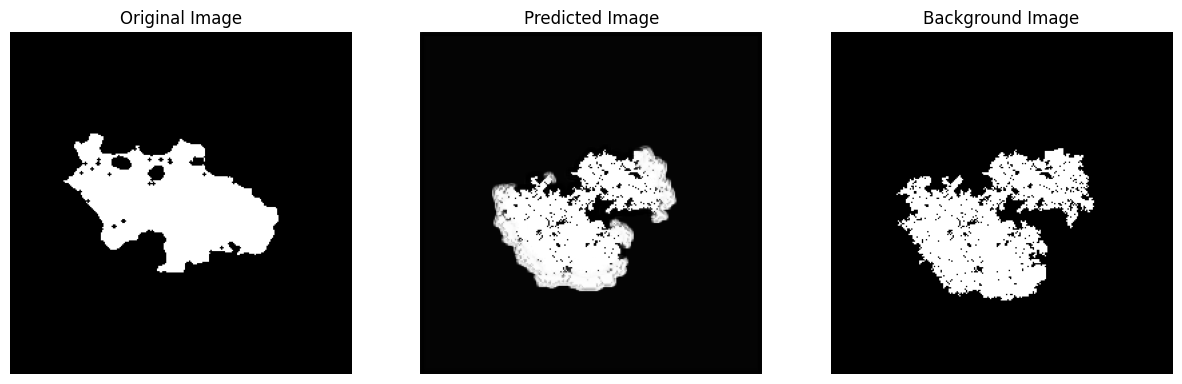

In [19]:
# Plot original, augmented, and background images for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sensors_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rnn_pred_image, cmap='gray')
plt.title('Predicted Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(model_image, cmap='gray')
plt.title('Background Image')
plt.axis('off')

plt.show()

### Compress the sensors data and model data

In [20]:
# Flatten the images for IPCA
rnn_pred_flattened = rnn_pred_image.flatten().reshape(1, -1)
model_flattened = model_image.flatten().reshape(1, -1)
sensors_flattened = sensors_image.flatten().reshape(1, -1)

# Transform the images using the trained IPCA model
rnn_pred_ipca = ipca.transform(rnn_pred_flattened)
model_ipca = ipca.transform(model_flattened)
sensors_ipca = ipca.transform(sensors_flattened)

In [21]:
# Define the data assimilation function
def update_prediction(x, K, H, y):
    res = x + np.dot(K, (y - np.dot(H, x)))
    return res

def mse(y_obs, y_pred):
    return np.square(np.subtract(y_obs, y_pred)).mean()

In [22]:
# Compute covariance matrices
model_reduced = model_ipca
sensors_reduced = sensors_ipca

print("Reduced Background Shape:", background_reduced.shape)
print("Reduced Obs Shape:", obs_reduced.shape)
print("Covariance Matrix (Background) Shape:", B.shape)
print("Covariance Matrix (Obs) Shape:", R.shape)
print("Kalman Gain Shape:", K.shape)

print("R Matrix:", R)
print("B Matrix:", B)
print("Kalman Gain:", K)

Reduced Background Shape: (5, 307)
Reduced Obs Shape: (5, 307)
Covariance Matrix (Background) Shape: (307, 307)
Covariance Matrix (Obs) Shape: (307, 307)
Kalman Gain Shape: (307, 307)
R Matrix: [[1.01416458e+02 6.13746117e+01 1.87447190e+01 ... 1.20174300e+00
  2.89239070e+00 3.51258331e+00]
 [6.13746117e+01 3.81348198e+01 1.15463817e+01 ... 7.33517202e-01
  1.51264602e+00 1.81730308e+00]
 [1.87447190e+01 1.15463817e+01 4.54480696e+00 ... 7.79569015e-02
  4.43439061e-01 7.27518620e-01]
 ...
 [1.20174300e+00 7.33517202e-01 7.79569015e-02 ... 3.70428075e-02
  2.83814348e-02 6.21536182e-03]
 [2.89239070e+00 1.51264602e+00 4.43439061e-01 ... 2.83814348e-02
  1.85876339e-01 2.27301501e-01]
 [3.51258331e+00 1.81730308e+00 7.27518620e-01 ... 6.21536182e-03
  2.27301501e-01 3.14706098e-01]]
B Matrix: [[3.04097469e+06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.64863832e+05 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00

In [23]:
print("Start Assimilation")

# Perform data assimilation for the RNN-predicted image
updated_data = update_prediction(rnn_pred_ipca[0], K, H, sensors_ipca[0])

# Convert to array format
updated_data_array = np.array([updated_data])

# Compute MSE before and after Data Assimilation
mse_before_DA = mse(sensors_ipca[0], rnn_pred_ipca[0])
mse_after_DA = mse(sensors_ipca[0], updated_data_array[0])

print(f'MSE before Data Assimilation in reduced space: {mse_before_DA:.8f}')
print(f'MSE after Data Assimilation in reduced space: {mse_after_DA:}')

Start Assimilation
MSE before Data Assimilation in reduced space: 9.67437331
MSE after Data Assimilation in reduced space: 0.008098867734200621


In [24]:
# Reconstruct the images from IPCA components for visualization
updated_image_reconstructed = ipca.inverse_transform(updated_data_array).reshape((256, 256))

# Binarised processing functions
def binarize_image(image, threshold=0.5):
    binary_image = np.where(image > threshold, 1.0, 0.0)
    return binary_image

# Binarise updated_image_reconstructed
rnn_pred_reconstructed = binarize_image(updated_image_reconstructed)

# Compute MSE between predict image and model image
mse_q_model = mse(sensors_image, model_image)
print(f'MSE between Satellite and Predicted Image: {mse_q_model:.4f}')

# Compute MSE between predict image and model image
mse__before_assimilation_model = mse(rnn_pred_image, model_image)
print(f'MSE between Background and Predicted Image: {mse__before_assimilation_model:.4f}')

# Compute MSE between reconstructed assimilated image and reconstructed image
mse_after_assimilation_model = mse(rnn_pred_reconstructed, model_image)
print(f'MSE between Background and reconstructed predicted Image: {mse_after_assimilation_model:.4f}')

# Compute MSE between obervation image and model image
mse_before_assimilation_sensors = mse(rnn_pred_image, sensors_image)
print(f'MSE between Satellite and Predicted Image: {mse_before_assimilation_sensors:.4f}')

# Compute MSE between reconstructed assimilated image and reconstructed image
mse_after_assimilation_sensors = mse(rnn_pred_reconstructed, sensors_image)
print(f'MSE between Satellite and reconstructed predicted Image: {mse_after_assimilation_sensors:.4f}')


MSE between Satellite and Predicted Image: 0.1185
MSE between Background and Predicted Image: 0.0182
MSE between Background and reconstructed predicted Image: 0.0819
MSE between Satellite and Predicted Image: 0.1004
MSE between Satellite and reconstructed predicted Image: 0.0544


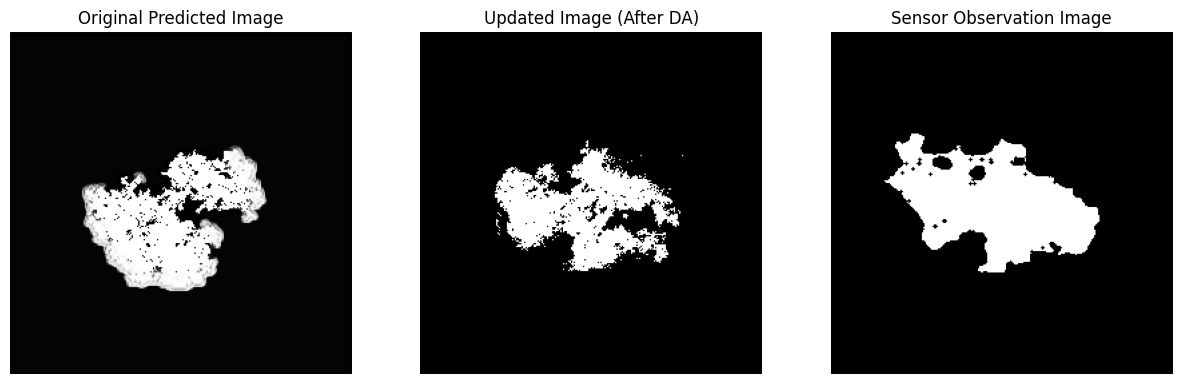

In [25]:
# Plot original, predicted, and sensor images for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(rnn_pred_image, cmap='gray')
plt.title('Original Predicted Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rnn_pred_reconstructed,cmap='gray')
plt.title('Updated Image (After DA)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sensors_image, cmap='gray')
plt.title('Sensor Observation Image')
plt.axis('off')

plt.show()

In [26]:
# Save NumPy arrays as .npy files
save_path = './Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/assimilation_pred.npy'
np.save(save_path, rnn_pred_reconstructed)
print(f"NumPy array saved to {save_path}")

NumPy array saved to ./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/assimilation_pred.npy


In [27]:
# Convert NumPy arrays to PIL image objects
rnn_pred_image = Image.fromarray((rnn_pred_reconstructed * 255).astype(np.uint8))

# Save images as files
save_path = './Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/assimilation_pred.png'

rnn_pred_image.save(save_path)
print(f"Image saved to {save_path}")

Image saved to ./Mydrive/acds3-wildfire-logan/acds3-wildfire-logan/assimilation_pred.png
